In [1]:
import sys
sys.path.append('../libmitigation')

In [2]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from sgs_algorithm import sgs_algorithm
from lib_grover import *

In [4]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 3  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.277010676691031e-06


In [5]:
#setting the number of shots and Grover operators.

number_grover_list = [0, 1, 2, 4, 8, 16, 32, 64, 128] # list of number of Grover operators
# number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [6]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.990, 0.010],[0.010,0.990]])
        noise_model.add_readout_error(read_err, [qi])

In [7]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [8]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.70823073387146 s
1 th round with 1 oracles
0.010178804397583008 s
2 th round with 2 oracles
0.012629032135009766 s
3 th round with 4 oracles
0.0182039737701416 s
4 th round with 8 oracles
0.02838301658630371 s
5 th round with 16 oracles
0.048722028732299805 s
6 th round with 32 oracles
0.09128689765930176 s
7 th round with 64 oracles
0.17855095863342285 s
8 th round with 128 oracles
0.41921114921569824 s


In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[97, 97, 96, 97, 92, 96, 92, 92, 80]


In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)
print(mit_hit_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  8
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  8
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  8
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  8
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  8
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999999
number of positive values:  8
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  9
main process: Done!
strict inverse + SGS algori

In [12]:
meas_filter.pinvVs

[array([[ 0.67913611,  0.73401236],
        [ 0.73401236, -0.67913611]]),
 array([[ 0.7009436 ,  0.71321671],
        [ 0.71321671, -0.7009436 ]]),
 array([[-0.73670185, -0.6762177 ],
        [-0.6762177 ,  0.73670185]]),
 array([[-0.70922452, -0.70498268],
        [-0.70498268,  0.70922452]])]

In [13]:
from draw_heatmap import *

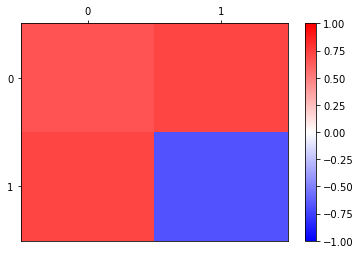

In [14]:
draw_heatmap(meas_filter.pinvVs[0])

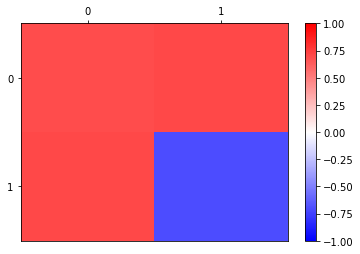

In [17]:
draw_heatmap(meas_filter.pinvVs[1])

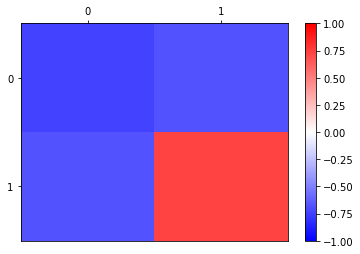

In [18]:
draw_heatmap(meas_filter.pinvVs[2])

draw_heatmap(meas_filter.pinvVs[0])

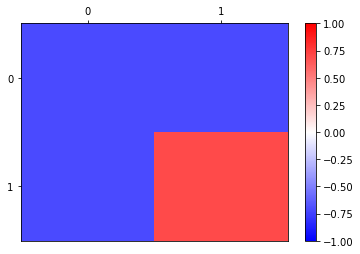

In [19]:
draw_heatmap(meas_filter.pinvVs[3])

draw_heatmap(meas_filter.pinvVs[0])

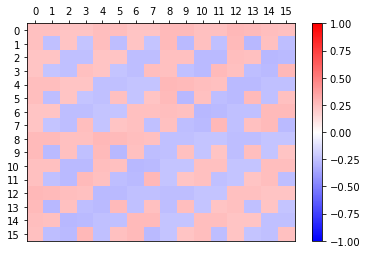

In [16]:
draw_heatmap(meas_filter.kron_matrices(meas_filter.pinvVs))

In [ ]:
meas_filter.pinvSigmas

In [21]:
meas_filter.pinvSigmas

[array([[0.99996608, 0.        ],
        [0.        , 1.0222458 ]]),
 array([[0.99999838, 0.        ],
        [0.        , 1.0213207 ]]),
 array([[0.99995996, 0.        ],
        [0.        , 1.02161467]]),
 array([[0.99999981, 0.        ],
        [0.        , 1.02055582]])]

In [20]:
[meas_filter.sum_of_tensored_vector(meas_filter.choose_vecs(state_idx, meas_filter.pinvSigmas)) for state_idx in range(2 ** meas_filter.num_clbits)]

[0.9999242337611408,
 1.020478682427167,
 1.0215781640524193,
 1.0425777310419764,
 1.02124497098841,
 1.042237688859305,
 1.0433606140196043,
 1.0648079411839364,
 1.0222030260039772,
 1.043215437659633,
 1.044339416263633,
 1.065806863692881,
 1.043998799498108,
 1.0654592452070404,
 1.0666071896793092,
 1.0885323735951085]

In [23]:
deltas = meas_filter.listup_deltas(counts_list[0])

sum_of_x:  1.0000000000000004
delta_denom:  16.000102758579253
delta_coeff:  -2.7755397359053963e-17
sum_of_x == sum_x
sum_of_x:  1.0000000000000004
sum_x:  1.0000726389213863
False


In [24]:
deltas

[-1.108485909167635e-16,
 3.1922556654378954e-19,
 4.546166124550756e-18,
 -1.3092204823800143e-20,
 -9.222754715788869e-19,
 2.656000473161514e-21,
 3.78247253458044e-20,
 -1.0892893881659275e-22,
 -4.118951436114873e-18,
 1.1861897340196854e-20,
 1.6892806063359075e-19,
 -4.864848115335535e-22,
 -3.4270240575325975e-20,
 9.869261190216865e-23,
 1.4055046211705208e-21,
 -4.047620319413746e-24]

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


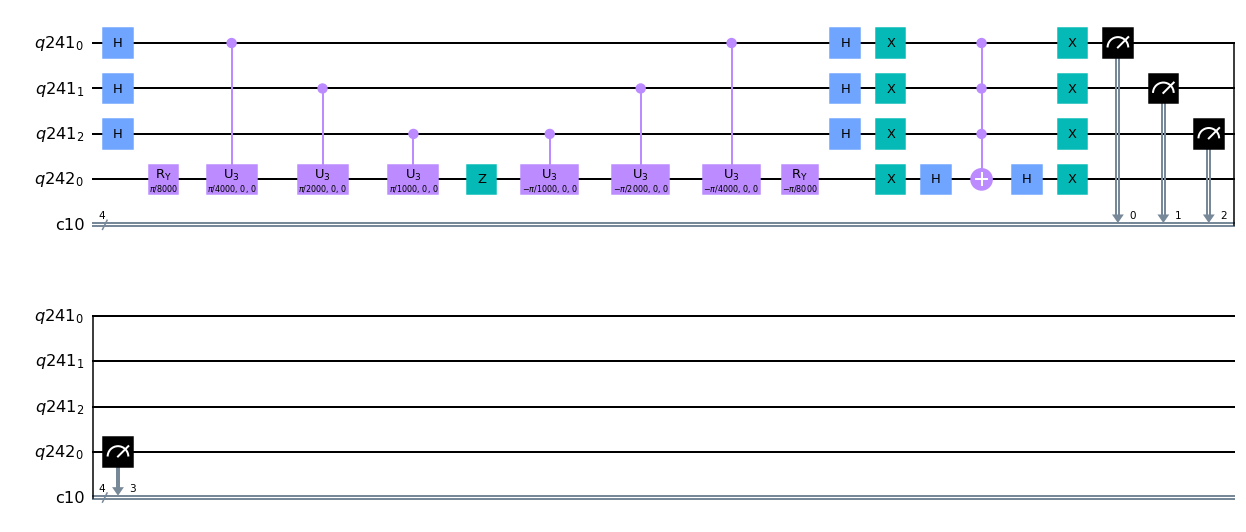

In [15]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )